In [1]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

pd.options.display.max_columns = 999
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier

import joblib

# Load Data

In [3]:
base_2018_encoded = pd.read_csv("../data/processed/base_tratada.csv")

In [4]:
print("Formato do banco de dados",base_2018_encoded.shape)
base_2018_encoded.describe()

Formato do banco de dados (9929, 447)


,ano_ingresso,frequentou_cursinho,escolaridade_pai,escolaridade_mae,forma_ingresso [Ampla concorrência],forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial],"forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]",forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)],forma_ingresso [Reserva de vagas (pessoa com deficiência)],forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)],"forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]",forma_ingresso [Transferência externa],forma_ingresso [Prefiro não responder],idade,sexo_biologico,nmr_filhos,meio_transporte [Caminhando (percurso total)],meio_transporte [Caminhando (parte do percurso)],meio_transporte [Bicicleta],meio_transporte [Carona],meio_transporte [Fretado/van],meio_transporte [Metrô],meio_transporte [Ônibus da UFABC],meio_transporte [Transporte particular (carro)],meio_transporte [Transporte particular (moto)],meio_transporte [Uber/taxi],meio_transporte [Trem],meio_transporte [Trólebus/ônibus - exceto ônibus da UFABC],meio_transporte [Prefiro não responder],tempo_medio_chegada_na_ufabc,atividade_extraclasse [Não participo de atividades extraclasse relacionadas à UFABC],atividade_extraclasse [AIESEC],atividade_extraclasse [Atividades culturais],atividade_extraclasse [Atividades de extensão],atividade_extraclasse [Atividades esportivas],atividade_extraclasse [AXIS  Atlética UFABC/CAAP],atividade_extraclasse [Coletivos de cunho religioso],atividade_extraclasse [Coletivos relacionados ao ativismo político],atividade_extraclasse [Coletivos relacionados ao empreendedorismo],atividade_extraclasse [Cursos de idiomas],atividade_extraclasse [DCE/Diretório Acadêmico/Centros Acadêmicos.],atividade_extraclasse [Empresas júniores],atividade_extraclasse [ENACTUS UFABC],atividade_extraclasse [Coletivos LGBTQ+],atividade_extraclasse [Coletivos feministas],atividade_extraclasse [Coletivos étnico-raciais],atividade_extraclasse [GPDA UFABC],atividade_extraclasse [Infanteria UFABC],atividade_extraclasse [Ramo Estudantil IEEE da UFABC],"atividade_extraclasse [Representação discente (ConsUni, ConsEPE, Comissões, etc)]",atividade_extraclasse [UFABC Cheer],atividade_extraclasse [Outras atividades extraclasse (não listadas acima)],atividade_extraclasse [Prefiro não responder],nivel_conhecimento_idioma [Alemão],nivel_conhecimento_idioma [Espanhol],nivel_conhecimento_idioma [Francês],nivel_conhecimento_idioma [Inglês],nivel_conhecimento_idioma [Italiano],nivel_conhecimento_idioma [Japonês],nivel_conhecimento_idioma [Libras],dificuldades [Nenhuma],dificuldades [Acessibilidade nas dependências da UFABC],dificuldades [Assuntos familiares/pessoais],dificuldades [Déficit de formação acadêmica básica],dificuldades [Didática dos docentes],dificuldades [Discriminações e preconceitos],dificuldades [Falta de disciplina/hábito de estudo],dificuldades [Problemas de saúde/psicológicos],dificuldades [Questões financeiras],dificuldades [Questões profissionais],dificuldades [Prefiro não responder],dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder],preconceito_discriminacao [Não],"preconceito_discriminacao [Sim, pela instituição de ensino em que cursei o ensino médio]","preconceito_discrimi

## Utils

In [5]:
def addlabels(ax,ref='vertical'):
    rects = ax.patches
    if ref=='vertical':
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
                    '{:.2%}'.format(height),
                    ha='center', va='center',color='white')
    if ref=='horizontal':
        for rect in rects:
            height = rect.get_width()
            ax.text(height+0.05*ax.get_xlim()[1],rect.get_y() + rect.get_height()/2.,
                    '{:.2%}'.format(height),
                    ha='center', va='center',color='black')

# Target Analysis

In [6]:
for c in base_2018_encoded.columns:
    if "tranc" in c:
        print(c)

trancamento_matricula
motivo_trancamento_matricula [Acessibilidade interna nas dependências da UFABC]
motivo_trancamento_matricula [Assuntos familiares/pessoais]
motivo_trancamento_matricula [Déficit de formação acadêmica básica]
motivo_trancamento_matricula [Didática dos docentes]
motivo_trancamento_matricula [Dificuldades acadêmicas]
motivo_trancamento_matricula [Discriminações e preconceitos]
motivo_trancamento_matricula [Intercâmbio/Mobilidade acadêmica]
motivo_trancamento_matricula [Licença-maternidade]
motivo_trancamento_matricula [Problemas de saúde/psicológicos]
motivo_trancamento_matricula [Questões financeiras]
motivo_trancamento_matricula [Questões profissionais]
motivo_trancamento_matricula [Outro(s), não listado(s) acima]
motivo_trancamento_matricula [Prefiro não responder]


In [7]:
tranc = base_2018_encoded['trancamento_matricula']

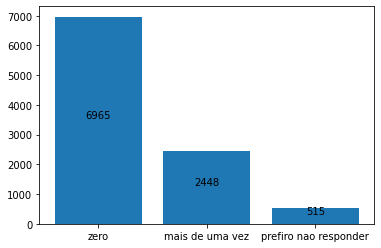

In [8]:
fig,ax = plt.subplots(1,1)
mais_um = (tranc>=1).astype(int).sum()
pref_nao_resp = (tranc==-1).astype(int).sum()
zero = (tranc==0).astype(int).sum()
rect = plt.bar(['zero','mais de uma vez','prefiro nao responder'],[zero,mais_um,pref_nao_resp])
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rect)
plt.show()

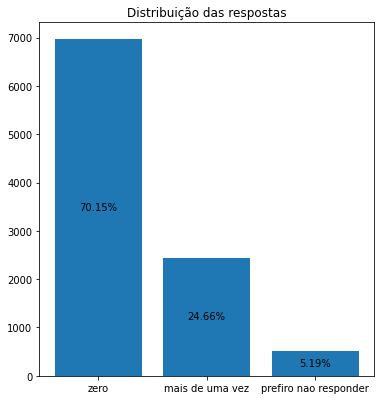

In [9]:
fig,ax = plt.subplots(1,1,figsize=(6,6.5))
mais_um = ((tranc>=1).astype(int).sum())
pref_nao_resp = ((tranc==-1).astype(int).sum())
zero = ((tranc==0).astype(int).sum())
rects = plt.bar(['zero','mais de uma vez','prefiro nao responder'],[zero,mais_um,pref_nao_resp])
ax.set_title('Distribuição das respostas')
"""
Attach a text label above each bar displaying its height
"""
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
            '{:.2%}'.format(height/len(tranc)),
            ha='center', va='center',color='black')
plt.show()
fig.savefig('../output/figures/distribuicao_resp_trancamento.png')

## Motivos

In [10]:
motivos=[]
for c in base_2018_encoded.columns:
    if "motivo_tranc" in c:
        motivos.append(c)

In [11]:
df_motivos = pd.DataFrame(columns=motivos)
motivos_tratados = []
for c in df_motivos.columns:
    motivos_tratados.append(c.split('[')[1].replace(']',''))
    df_motivos[c]=base_2018_encoded[c].replace(1,c.split('[')[1].replace(']',''))
df_motivos=df_motivos.replace(0,np.nan)
df_motivos['todos_motivos']=df_motivos.apply(lambda row: '__'.join(row.dropna().values.astype(str)), axis=1)

In [12]:
df_motivos['todos_motivos'].max()

'Questões profissionais__Outro(s), não listado(s) acima'

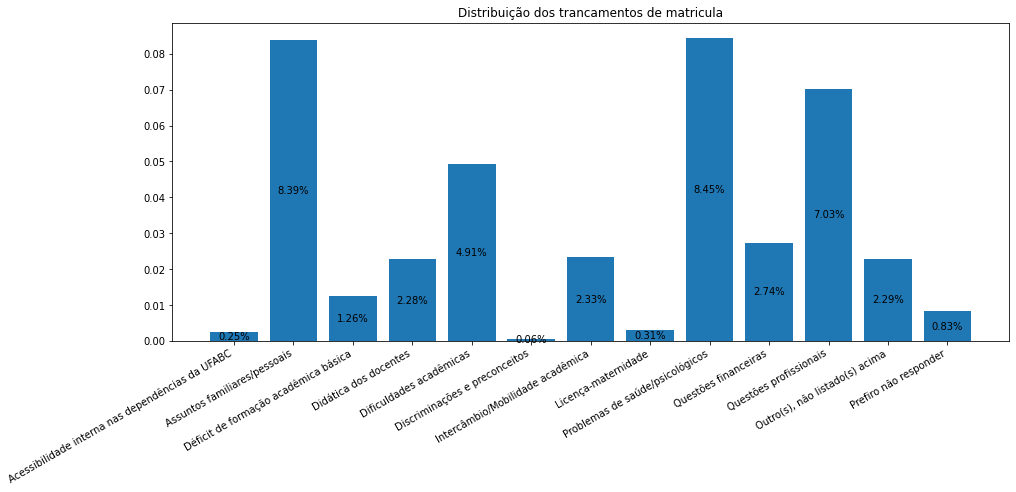

In [13]:
fig,ax = plt.subplots(1,1,figsize=(15,6.5))
rects = plt.bar(motivos_tratados,df_motivos[motivos].count()/len(df_motivos))
"""
Attach a text label above each bar displaying its height
"""
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 0.5*height,
            '{:.2%}'.format(height),
            ha='center', va='center',color='black')
ax.set_title('Distribuição dos trancamentos de matricula')
fig.autofmt_xdate()
plt.show()
fig.savefig('../output/figures/dist_trancamento_matricula.png')

In [14]:
base_2018_encoded.filter(regex='dificuldades_emocionais ').head()

,dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder]
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [15]:
((base_2018_encoded.filter(regex='dificuldades_emocionais ').sum(axis=1)>0)&(base_2018_encoded['motivo_trancamento_matricula [Problemas de saúde/psicológicos]']>0)).value_counts(normalize=True)

False    0.9155
True     0.0845
dtype: float64

In [16]:
(base_2018_encoded.filter(regex='dificuldades_emocionais ').sum(axis=1)>0).sum()

9929

In [17]:
base_2018_encoded.filter(regex='dificuldades_emocionais ')

,dificuldades_emocionais [Nenhuma],dificuldades_emocionais [Ansiedade],"dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]",dificuldades_emocionais [Distúrbios alimentares],"dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]",dificuldades_emocionais [Medo/pânico],dificuldades_emocionais [Pensamento suicida],dificuldades_emocionais [Sensação de desamparo/desespero/desesperança],dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental],dificuldades_emocionais [Sentimento de solidão],dificuldades_emocionais [Timidez excessiva],dificuldades_emocionais [Tristeza persistente],dificuldades_emocionais [Prefiro não responder]
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9924,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9925,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9926,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
9927,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
base_2018_encoded.filter(regex='dificuldades_emocionais ').columns

Index(['dificuldades_emocionais [Nenhuma]',
       'dificuldades_emocionais [Ansiedade]',
       'dificuldades_emocionais [Desânimo, falta de vontade de fazer as coisas]',
       'dificuldades_emocionais [Distúrbios alimentares]',
       'dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]',
       'dificuldades_emocionais [Medo/pânico]',
       'dificuldades_emocionais [Pensamento suicida]',
       'dificuldades_emocionais [Sensação de desamparo/desespero/desesperança]',
       'dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental]',
       'dificuldades_emocionais [Sentimento de solidão]',
       'dificuldades_emocionais [Timidez excessiva]',
       'dificuldades_emocionais [Tristeza persistente]',
       'dificuldades_emocionais [Prefiro não responder]'],
      dtype='object')

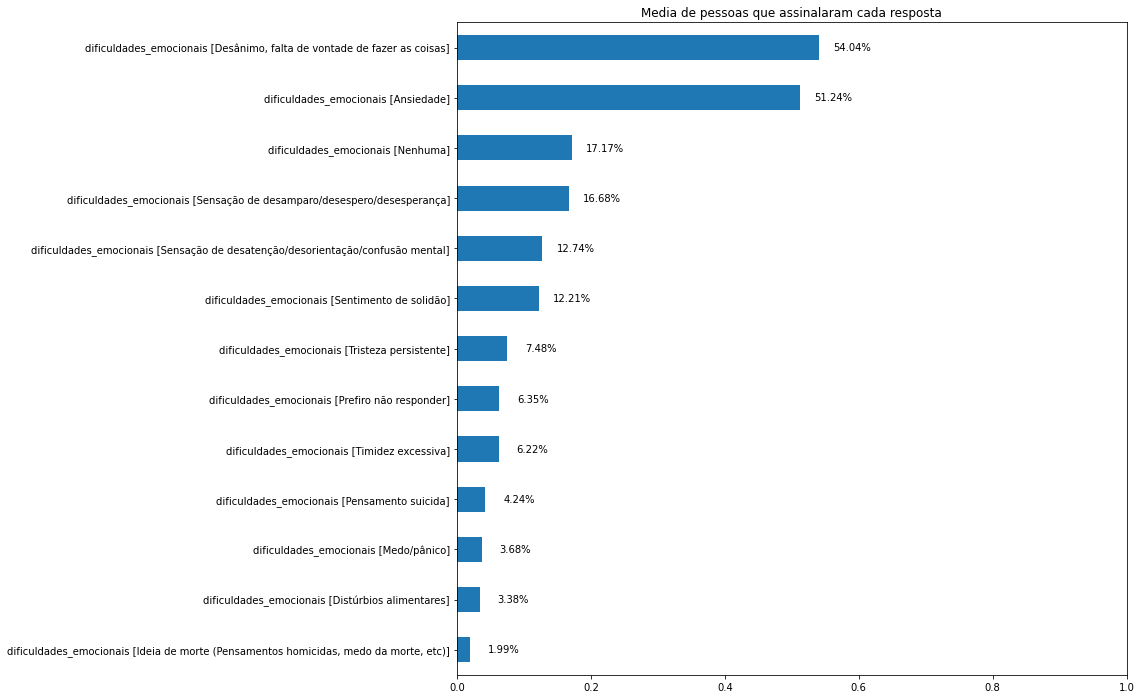

In [19]:
fig,axs = plt.subplots(figsize=(12,12))

base_2018_encoded.filter(regex='dificuldades_emocionais ').fillna(0).mean().sort_values().plot(kind='barh',ax=axs)
axs.set_xlim(0,1)
addlabels(axs,'horizontal')
axs.set_title('Media de pessoas que assinalaram cada resposta')
plt.show()

In [20]:
target_columns = ['dificuldades_emocionais [Ansiedade]',
       'dificuldades_emocionais [Distúrbios alimentares]',
       'dificuldades_emocionais [Ideia de morte (Pensamentos homicidas, medo da morte, etc)]',
       'dificuldades_emocionais [Medo/pânico]',
       'dificuldades_emocionais [Pensamento suicida]',
       'dificuldades_emocionais [Sensação de desamparo/desespero/desesperança]',
       'dificuldades_emocionais [Sensação de desatenção/desorientação/confusão mental]',
       'dificuldades_emocionais [Sentimento de solidão]',
       'dificuldades_emocionais [Timidez excessiva]',
       'dificuldades_emocionais [Tristeza persistente]']

target = base_2018_encoded[target_columns].max(axis=1).fillna(0)

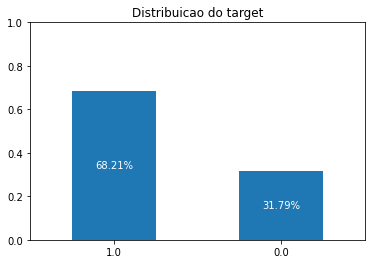

In [21]:
fig,axs=plt.subplots()
target.value_counts(normalize=True).plot(kind='bar',title='Distribuicao do target',rot=0,ax=axs)
addlabels(axs)
axs.set_ylim(0,1)
plt.show()

## Data Pruning
<p>Em teoria, não seria necessária a retirada de nenhum dado 
(não foi identificado a existência de ruido ou outliers negativos),<br>
mas alguns dados seriam impossíveis de serem coletados de ingressantes, então 
serão descartados </p>

In [22]:
X = base_2018_encoded.copy()

In [23]:
columns = {}
for c in X.columns:
    c = c.split('[')[0]
    if c in columns:
        columns[c]+=1
    else:
        columns[c]=1

In [24]:
print('numero de colunas:',len(columns))
list(columns.keys())

numero de colunas: 66


['ano_ingresso',
 'frequentou_cursinho',
 'escolaridade_pai',
 'escolaridade_mae',
 'forma_ingresso ',
 'idade',
 'sexo_biologico',
 'nmr_filhos',
 'meio_transporte ',
 'tempo_medio_chegada_na_ufabc',
 'atividade_extraclasse ',
 'nivel_conhecimento_idioma ',
 'dificuldades ',
 'dificuldades_emocionais ',
 'preconceito_discriminacao ',
 'assedio ',
 'fumante',
 'consome_bebidas_alcoolicas',
 'doenca_cronica ',
 'favoravel_cotas ',
 'pdv_diversidade ',
 'pos-bct_pretende ',
 'pos-bct_matriculado ',
 'pos-bch_pretende ',
 'pos-bch_matriculado ',
 'deseja_solicitar_transf_interna',
 'possui_reprovacoes',
 'trancamento_matricula',
 'motivo_trancamento_matricula ',
 'mobilidade_academica',
 'programa_desenv_acad ',
 'CR',
 'CA',
 'horas_semanais_na_ufabc',
 'obj_pos_conclusao ',
 'nota_infraestrutura_sa ',
 'nota_infraestrutura_sbc ',
 'nota ',
 'renda_familiar_mensal',
 'qtd_pessoas_familia',
 'principal_mantedor_familia ',
 'salario_mensal',
 'atividade_remunerada',
 'programa_assist_estud

In [25]:
remover =['possui_reprovacoes',
          'trancamento_matricula',
          'motivo_trancamento_matricula ',
          'mobilidade_academica',
          'programa_desenv_acad ',
          'ano_ingresso',
          'pos-bct_matriculado',
          'pos-bct_matriculado',
          'nota']

#Removendo colunas de dificultades devido a obviedade de relacao
remover = remover + ['dificuldades_emocionais','dificuldades'] 
remover = remover +['CR','CA']

In [26]:
for r in remover:
    contem = []
    for c in X.columns:
        if r in c:
            contem.append(c)
    X.drop(contem,axis=1,inplace=True)

In [27]:
columns = {}
for c in X.columns:
    c = c.split('[')[0]
    if c in columns:
        columns[c]+=1
    else:
        columns[c]=1

In [28]:
print('numero de colunas:',len(columns))
list(columns.keys())

numero de colunas: 51


['frequentou_cursinho',
 'escolaridade_pai',
 'escolaridade_mae',
 'forma_ingresso ',
 'idade',
 'sexo_biologico',
 'nmr_filhos',
 'meio_transporte ',
 'tempo_medio_chegada_na_ufabc',
 'atividade_extraclasse ',
 'nivel_conhecimento_idioma ',
 'preconceito_discriminacao ',
 'assedio ',
 'fumante',
 'consome_bebidas_alcoolicas',
 'doenca_cronica ',
 'favoravel_cotas ',
 'pdv_diversidade ',
 'pos-bct_pretende ',
 'pos-bch_pretende ',
 'pos-bch_matriculado ',
 'deseja_solicitar_transf_interna',
 'horas_semanais_na_ufabc',
 'obj_pos_conclusao ',
 'renda_familiar_mensal',
 'qtd_pessoas_familia',
 'principal_mantedor_familia ',
 'salario_mensal',
 'atividade_remunerada',
 'programa_assist_estudantil ',
 'frequencia_ru',
 'valor_gasto_alimentacao_interna',
 'como_conheceu ',
 'motivo_escolha ',
 'estado_civil ',
 'identidade_genero ',
 'orientacao_sexual ',
 'cor/raca ',
 'onde_reside ',
 'regiao_sp_reside ',
 'consome_subst_psicoativas ',
 'dieta_alimentar ',
 'religiao ',
 'campus_atual ',
 

In [29]:
    X.filter(regex='(?i)sexo_biologico').mean()

sexo_biologico    0.308994
dtype: float64

In [30]:
drop_cols = X.filter(regex='(?i)sexo_biologico').columns
X

,frequentou_cursinho,escolaridade_pai,escolaridade_mae,forma_ingresso [Ampla concorrência],forma_ingresso [PEC-G/Transferência Ex Officio/Decisão Judicial],"forma_ingresso [Reserva de vagas (autodeclarado preto, pardo ou indígena)]",forma_ingresso [Reserva de vagas (cursado integralmente o ensino médio em escolas públicas)],forma_ingresso [Reserva de vagas (pessoa com deficiência)],forma_ingresso [Reserva de vagas (refugiado ou solicitante de refúgio - incluindo situação de vulnerabilidade econômica)],"forma_ingresso [Reserva de vagas (renda familiar bruta per capita igual ou inferior a 1,5 salário mínimo)]",forma_ingresso [Transferência externa],forma_ingresso [Prefiro não responder],idade,sexo_biologico,nmr_filhos,meio_transporte [Caminhando (percurso total)],meio_transporte [Caminhando (parte do percurso)],meio_transporte [Bicicleta],meio_transporte [Carona],meio_transporte [Fretado/van],meio_transporte [Metrô],meio_transporte [Ônibus da UFABC],meio_transporte [Transporte particular (carro)],meio_transporte [Transporte particular (moto)],meio_transporte [Uber/taxi],meio_transporte [Trem],meio_transporte [Trólebus/ônibus - exceto ônibus da UFABC],meio_transporte [Prefiro não responder],tempo_medio_chegada_na_ufabc,atividade_extraclasse [Não participo de atividades extraclasse relacionadas à UFABC],atividade_extraclasse [AIESEC],atividade_extraclasse [Atividades culturais],atividade_extraclasse [Atividades de extensão],atividade_extraclasse [Atividades esportivas],atividade_extraclasse [Coletivos de cunho religioso],atividade_extraclasse [Coletivos relacionados ao ativismo político],atividade_extraclasse [Coletivos relacionados ao empreendedorismo],atividade_extraclasse [Cursos de idiomas],atividade_extraclasse [DCE/Diretório Acadêmico/Centros Acadêmicos.],atividade_extraclasse [Empresas júniores],atividade_extraclasse [ENACTUS UFABC],atividade_extraclasse [Coletivos LGBTQ+],atividade_extraclasse [Coletivos feministas],atividade_extraclasse [Coletivos étnico-raciais],atividade_extraclasse [GPDA UFABC],atividade_extraclasse [Infanteria UFABC],atividade_extraclasse [Ramo Estudantil IEEE da UFABC],"atividade_extraclasse [Representação discente (ConsUni, ConsEPE, Comissões, etc)]",atividade_extraclasse [UFABC Cheer],atividade_extraclasse [Outras atividades extraclasse (não listadas acima)],atividade_extraclasse [Prefiro não responder],nivel_conhecimento_idioma [Alemão],nivel_conhecimento_idioma [Espanhol],nivel_conhecimento_idioma [Francês],nivel_conhecimento_idioma [Inglês],nivel_conhecimento_idioma [Italiano],nivel_conhecimento_idioma [Japonês],nivel_conhecimento_idioma [Libras],preconceito_discriminacao [Não],"preconceito_discriminacao [Sim, pela instituição de ensino em que cursei o ensino médio]","preconceito_discriminacao [Sim, pela minha aparência física]","preconceito_discriminacao [Sim, pela minha condição socioeconômica]","preconceito_discriminacao [Sim, pela minha etnia/raça]","preconceito_discriminacao [Sim, pela minha idade]","preconceito_discriminacao [Sim, pela minha identidade de gênero]","preconceito_discriminacao [Sim, pela minha orientação sexual/afetiva]","preconceito_discriminacao [Sim, pelo meu local de moradia]","preconceito_discriminacao [Sim, pelo meu local de nascimento/origem]","preconceito_discriminacao [Sim, pelo meu posicionamento político-ideológico]","preconceito_discriminacao [Sim, pelo meu posicionamento religioso]","preconceito_discriminacao [Sim, pelo meu sexo de nascimento]","preconceito_discriminacao [Sim, pelo(s) grupo(s) de expressão(ões) cultural(is) do(s) qual(is) participo]","preconceito_discriminacao [Sim, pelos meus hábitos sociais (beber, fumar, etc)]","preconceito_discriminacao [Sim, por ser cotista]","preconceito_discriminacao [Sim, por ser pessoa com deficiência (PcD)]","preconceito_discriminacao [Sim, sem motivo racional/aparente]",preconceito_discriminacao [Prefiro não responder],assedio [Não],"assedio [Sim, moral]","assedio [Sim, psicológico (bullying)]","assedio [Sim, sexual]",

## Treino do Modelo

#### Preenchendo valores nulos com a média

In [31]:
X.fillna(base_2018_encoded.mean(),inplace=True)

In [32]:
y = target

In [33]:
print(f'Shape X: {X.shape}')
print(f'Shape y: {y.shape}')

Shape X: (9929, 329)
Shape y: (9929,)


In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [35]:
print('Distribuicao do y')
print('Treino')
print(y_train.value_counts(normalize=True))
print('\nTeste')
print(y_test.value_counts(normalize=True))

Distribuicao do y
Treino
1.0    0.685603
0.0    0.314397
dtype: float64

Teste
1.0    0.671768
0.0    0.328232
dtype: float64


In [36]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 300, num = 10)]
# Minimum number of samples for split
min_samples_split = range(2,10)
max_depth.append(None)
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split':min_samples_split}

rf = RandomForestClassifier(class_weight='balanced')

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 50,
    verbose=True,
    n_jobs = 3,
    cv = 5)

In [37]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=50, n_jobs=3,
                   param_distributions={'max_depth': [50, 77, 105, 133, 161,
                                                      188, 216, 244, 272, 300,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=True)

In [38]:
rf_random.best_score_

0.731802164418262

In [39]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 6,
 'max_features': 'sqrt',
 'max_depth': 300}

In [40]:
best_rf = rf_random.best_estimator_

In [41]:
best_rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=300,
                       max_features='sqrt', min_samples_split=6,
                       n_estimators=400)

## Precision vs. Recall

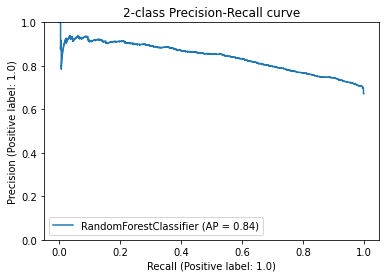

In [42]:
disp = plot_precision_recall_curve(best_rf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')
disp.ax_.set_ylim(0,1.0)
disp.ax_.get_figure().savefig('../output/figures/precision-recall-curve.png')

In [43]:
predict_p = [x[1] for x in best_rf.predict_proba(X_test)]
fpr,tpr, thresholds = roc_curve(y_test,predict_p)
aux_dict = {
    'fpr':fpr,
    'tpr':tpr,
    'thresholds': thresholds
}
df_scores = pd.DataFrame(aux_dict)

In [44]:
recalls = []
precisions = []
for i in thresholds:
    predictions_aux = predict_p>=i
    true_p = (predictions_aux==True) & (y_test==True)
    if(True in true_p.value_counts().index):
        tp = true_p.value_counts()[True]
    else:
        tp=0
    #print(tp)
    false_n = (predictions_aux==False) & (y_test==True)
    if(True in false_n.value_counts().index):
        fn = false_n.value_counts()[True]
    else:
        fn = 0
    false_p = (predictions_aux==True) & (y_test==False)
    if(True in false_p.value_counts().index):
        fp = false_p.value_counts()[True]
    else:
        fp = 0
    #print(fn)
    recalls.append(tp/(tp+fn))
    if((tp+fp)==0):
        precisions.append(0)
    else:
        precisions.append(tp/(tp+fp))
df_scores['recalls'] = recalls
df_scores['precisions'] = precisions

In [45]:
df_scores.loc[(df_scores['recalls']>0.75) & (df_scores['recalls']<=0.8)]

,fpr,tpr,thresholds,recalls,precisions
502,0.428221,0.751799,0.603839,0.751799,0.782283
503,0.429448,0.751799,0.603765,0.751799,0.781796
504,0.429448,0.752398,0.603658,0.752398,0.781931
505,0.430675,0.752398,0.603555,0.752398,0.781445
506,0.430675,0.752998,0.603452,0.752998,0.781581
...,...,...,...,...,...
573,0.494479,0.798561,0.583503,0.798561,0.767723
574,0.494479,0.799161,0.583272,0.799161,0.767857
575,0.495706,0.799161,0.582996,0.799161,0.767415
576,0.495706,0.799760,0.582921,0.799760,0.767549


In [46]:
def predict_with_th(classificator,threshold,X):
    predictions_p = classificator.predict_proba(X)
    predictions_p_p = [x[1] for x in predictions_p]
    return [x>=threshold for x in predictions_p_p]

In [47]:
predictions_with_th = predict_with_th(best_rf,0.290218,X_test)

In [48]:
print("ROC-Auc do modelo implementando o Threshold para Recall 0.8")
print("Acurácia: {0:.2%}".format(accuracy_score(y_test,predictions_with_th)))
print("Recall: {0:.2%}".format(recall_score(y_test,predictions_with_th)))
print("Precision: {0:.2%}".format(precision_score(y_test,predictions_with_th)))
print("ROC Auc: {0:.2%}".format(roc_auc_score(y_test,predictions_with_th)))

ROC-Auc do modelo implementando o Threshold para Recall 0.8
Acurácia: 71.41%
Recall: 99.64%
Precision: 70.25%
ROC Auc: 56.63%


## Roc Curve

In [49]:
def plot_roc_curve(fpr,tpr, thresholds):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.title('Roc Curve Analysis')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="center right")
    
    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])
    
    
    
    plt.savefig('../output/figures/roc_and_threshold.png')
    plt.show()
    plt.close()

In [50]:
predict_p = [x[1] for x in best_rf.predict_proba(X_test)]
fpr,tpr, thresholds = roc_curve(y_test,predict_p)

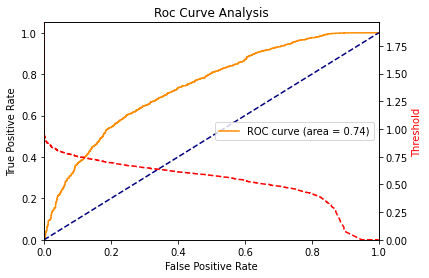

In [51]:
plot_roc_curve(fpr,tpr,thresholds)

# Compiling Results

In [52]:
results_df = pd.DataFrame(best_rf.predict_proba(X_test),columns=best_rf.classes_)
results_df['Predictions'] = best_rf.predict(X_test)
results_df['Real class'] = y_test.tolist()
results_df['Correct'] = results_df['Predictions']==results_df['Real class']
results_df['True Positive'] = (results_df['Predictions']==True) & (results_df['Real class']==True)
results_df['False Negative'] = (results_df['Predictions']==False) & (results_df['Real class']==True)

In [53]:
results_df 

,0.0,1.0,Predictions,Real class,Correct,True Positive,False Negative
0,0.475971,0.524029,1.0,1.0,True,True,False
1,0.275341,0.724659,1.0,0.0,False,False,False
2,0.434123,0.565877,1.0,0.0,False,False,False
3,0.380385,0.619615,1.0,0.0,False,False,False
4,0.212351,0.787649,1.0,0.0,False,False,False
...,...,...,...,...,...,...,...
2478,0.569472,0.430528,0.0,0.0,True,False,False
2479,0.346653,0.653347,1.0,0.0,False,False,False
2480,0.397145,0.602855,1.0,1.0,True,True,False
2481,0.488135,0.511865,1.0,0.0,False,False,False


# Analisando as Features

In [54]:
importances = best_rf.feature_importances_
dict_aux = {
    'name':X_train.columns.tolist(),
    'importance':importances
}
df_importancias = pd.DataFrame(dict_aux).sort_values('importance',ascending=False).reset_index().drop('index',axis=1)

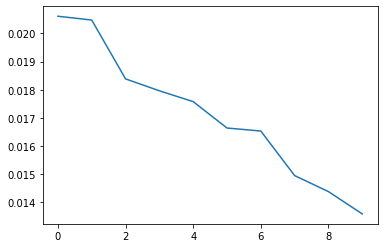

In [55]:
plt.plot(df_importancias['importance'].head(10))

In [56]:
df_importancias.head(20)

,name,importance
0,sexo_biologico,0.020606
1,idade,0.020471
2,renda_familiar_mensal,0.018383
3,salario_mensal,0.017962
4,frequencia_ru,0.017576
5,atividade_remunerada,0.016640
6,horas_semanais_na_ufabc,0.016533
7,valor_gasto_alimentacao_interna,0.014952
8,tempo_medio_chegada_na_ufabc,0.014384
9,qtd_pessoas_familia,0.013593


# Shap Value

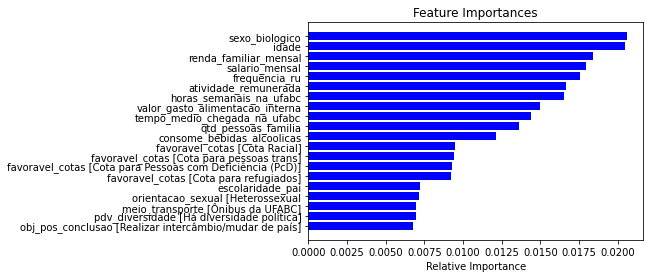

In [57]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]

features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [58]:
import shap

In [59]:
rf_shap_explainer = shap.TreeExplainer(best_rf)

In [60]:
X_test.shape

(2483, 329)

In [61]:
shap_values = rf_shap_explainer.shap_values(X_test)

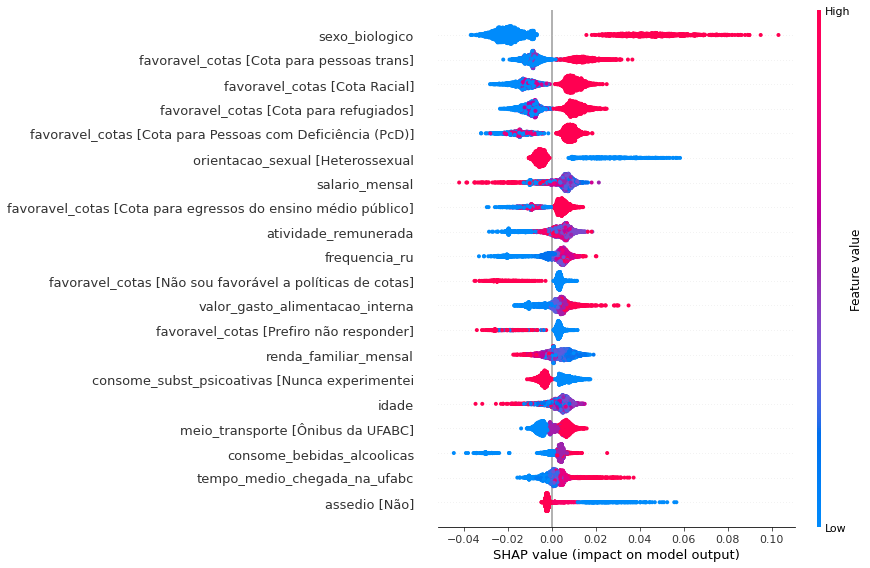

In [62]:
shap.summary_plot(shap_values[1], X_test,)